# Simulations

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from reflectorch import reflectivity

## Basic example

In order to compute reflectivity curves from the physical parameters of the structure use the `reflectivity` function, with the mandatory arguments: 

- `q`: tensor of momentum transfer values with shape [n_points] or [batch_size, n_points], in units of $Å^{-1}$
- `thickness`: tensor containing the layer thicknesses (ordered from top to bottom) with shape [batch_size, n_layers], in units of $Å$
- `roughness`: tensor containing the interlayer roughnesses (ordered from top to bottom) with shape [batch_size, n_layers + 1], in units of $Å$
- `sld` (Tensor): tensor containing the layer SLDs (real or complex; ordered from top to bottom) with shape  [batch_size, n_layers + 1] (excluding ambient SLD which is assumed to be 0 (air))  or [batch_size, n_layers + 2] (including ambient SLD), in units of in units of $10^{-6} Å^{-2}$

We initalize the grid of momentum transfer values (`q`) and the physical parameters for 2-layer structures inbetween the fronting medium (ambient) and the backing medium (substrate). Here we have a batch size of 2 (i.e. two different structures). In this example, the tensors are located on the CPU. Performing the computation on GPU (`'cuda'`) is computationally faster for large batch sizes. Notably, we use the double-precision data types (torch.float64 for real-valued tensors or torch.complex128 for complex-valued tensors) instead of the default single-precision data type for improved accuracy.

In [2]:
device = torch.device('cpu') # or 'cuda'

q = torch.linspace(0.005, 0.3, 256, dtype=torch.float64, device=device)

thickness = torch.tensor([
    [30, 250], #thicknesses structure 1 (top to bottom)
    [120, 170], #thicknesses structure 2 (top to bottom)
], dtype=torch.float64, device=device)

roughness = torch.tensor([
    [3, 10, 20], #roughnesses structure 1 (top to bottom)
    [30, 5, 0], #roughnesses structure 2 (top to bottom)
], dtype=torch.float64, device=device)

sld = torch.tensor([
    [2.07, -3.47, 2.0, 6.36], #slds structure 1 (top to bottom)
    [0.0, 15, 40 + 1j*5, 20], #slds structure 2 (top to bottom)
], dtype=torch.complex128, device=device)

print(q.shape, thickness.shape, roughness.shape, sld.shape)

torch.Size([256]) torch.Size([2, 2]) torch.Size([2, 3]) torch.Size([2, 4])


The q values and the physical provided as input to the `reflectivity` function.

In [3]:
sim_reflectorch = reflectivity(
    q=q,
    thickness=thickness,
    roughness=roughness,
    sld=sld,
)

print(sim_reflectorch.shape, sim_reflectorch.dtype, sim_reflectorch.device) # shape: [batch_size, n_points]

torch.Size([2, 256]) torch.float64 cpu


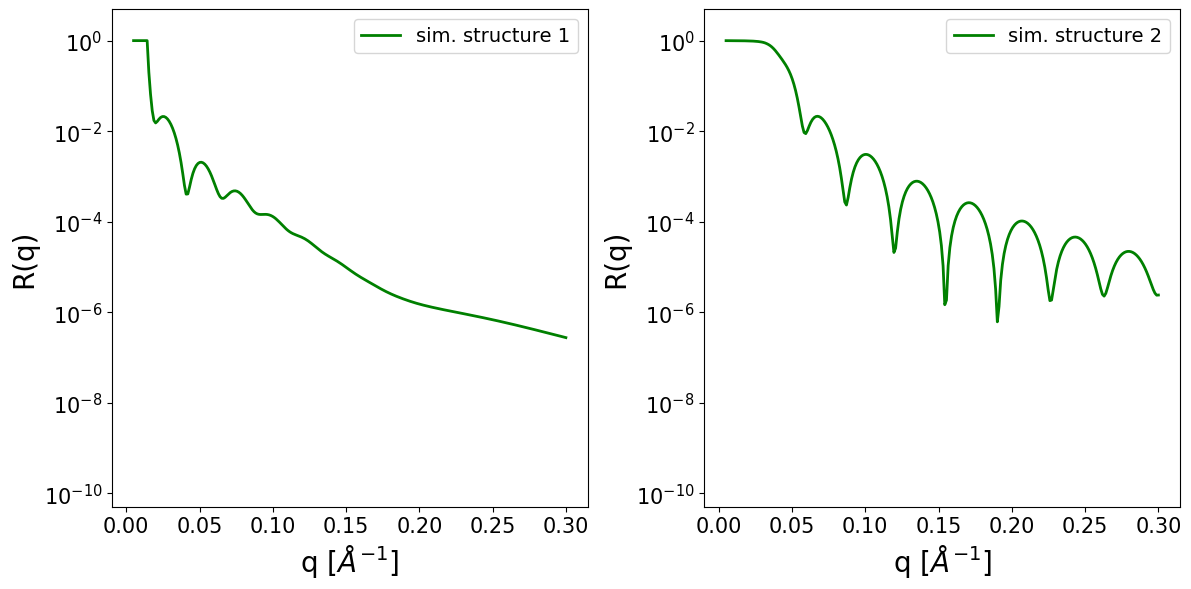

In [4]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(0.5e-10, 5)
    ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax.set_ylabel('R(q)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
axes[0].plot(q, sim_reflectorch[0], c='green', lw=2, label='sim. structure 1')
axes[1].plot(q, sim_reflectorch[1], c='green', lw=2, label='sim. structure 2')

axes[0].legend(loc='upper right', fontsize=14);
axes[1].legend(loc='upper right', fontsize=14);

plt.tight_layout()

## Comparison to refnx and refl1d

We compare our reflectivity simulations with simulations performed using the well-known classical analysis packages `refnx` and `refl1d`.

### refnx

In [5]:
from refnx.reflect import Slab, ReflectModel

### Structure 1
amb = Slab(thick=0, rough=0, sld=2.07)
l1 = Slab(thick=30, rough=3, sld=-3.47)
l2 = Slab(thick=250, rough=10, sld=2.0)
sub = Slab(thick=0, rough=20, sld=6.36)

structure1 = amb | l1 | l2 | sub
model1 = ReflectModel(structure1, bkg=0, dq=0)
sim_refnx_1 = model1(q.numpy())


### Structure 2
amb = Slab(thick=0, rough=0, sld=0.0)
l1 = Slab(thick=120, rough=30, sld=15)
l2 = Slab(thick=170, rough=5, sld=40+1j*5)
sub = Slab(thick=0, rough=0, sld=20)

structure2 = amb | l1 | l2 | sub
model2 = ReflectModel(structure2, bkg=0, dq=0)
sim_refnx_2 = model2(q.numpy())

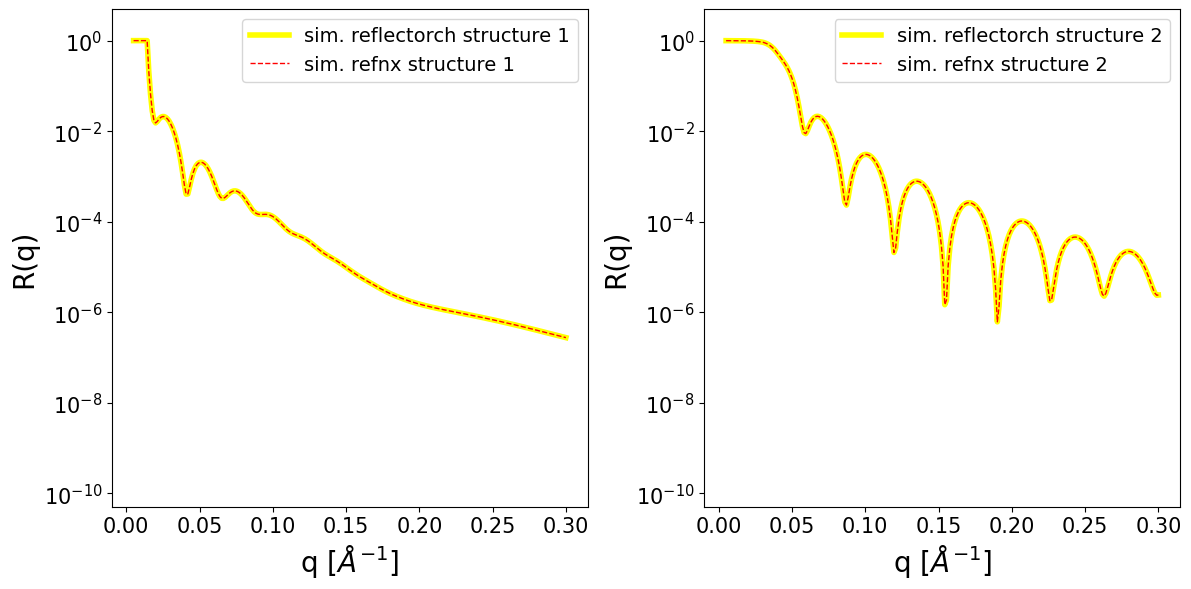

In [6]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(0.5e-10, 5)
    ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax.set_ylabel('R(q)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
axes[0].plot(q, sim_reflectorch[0], c='yellow', lw=4, label='sim. reflectorch structure 1')
axes[0].plot(q.numpy(), sim_refnx_1, c='red', lw=1, ls='--', label='sim. refnx structure 1')

axes[1].plot(q, sim_reflectorch[1], c='yellow', lw=4, label='sim. reflectorch structure 2')
axes[1].plot(q.numpy(), sim_refnx_2, c='red', lw=1, ls='--', label='sim. refnx structure 2')

axes[0].legend(loc='upper right', fontsize=14);
axes[1].legend(loc='upper right', fontsize=14);

plt.tight_layout()

In [7]:
print(f'Maximum relative difference (sim 1): {(np.abs((sim_reflectorch[0].numpy() - sim_refnx_1)) / sim_refnx_1).max()}')
print(f'Maximum relative difference (sim 2): {(np.abs((sim_reflectorch[1].numpy() - sim_refnx_2)) / sim_refnx_2).max()}')

Maximum relative difference (sim 1): 1.3252568794802023e-15
Maximum relative difference (sim 2): 4.861003460017665e-15


### refl1d

In [8]:
import refl1d
import refl1d.names

probe = refl1d.names.QProbe(
    Q=q.numpy(),
    dQ=np.zeros_like(q),
)

### Structure 1
sld_amb = refl1d.names.SLD(rho=2.07)
sld_l1 = refl1d.names.SLD(rho=-3.47)
sld_l2 = refl1d.names.SLD(rho=2.0)
sld_sub = refl1d.names.SLD(rho=6.36)

structure1 = sld_sub(0, 20) | sld_l2(250, 10) | sld_l1(30, 3) | sld_amb(0, 0) ### in refl1d the layer order is from substrate to ambient
experiment1 = refl1d.names.Experiment(probe=probe, sample=structure1)
sim_refl1d_1 = experiment1.reflectivity()[1]

### Structure 2
sld_amb = refl1d.names.SLD(rho=0)
sld_l1 = refl1d.names.SLD(rho=15)
sld_l2 = refl1d.names.SLD(rho=40, irho=5)
sld_sub = refl1d.names.SLD(rho=20)

structure2 = sld_sub(0, 0) | sld_l2(170, 5) | sld_l1(120, 30) | sld_amb(0, 0)
experiment2 = refl1d.names.Experiment(probe=probe, sample=structure2)
sim_refl1d_2 = experiment2.reflectivity()[1]

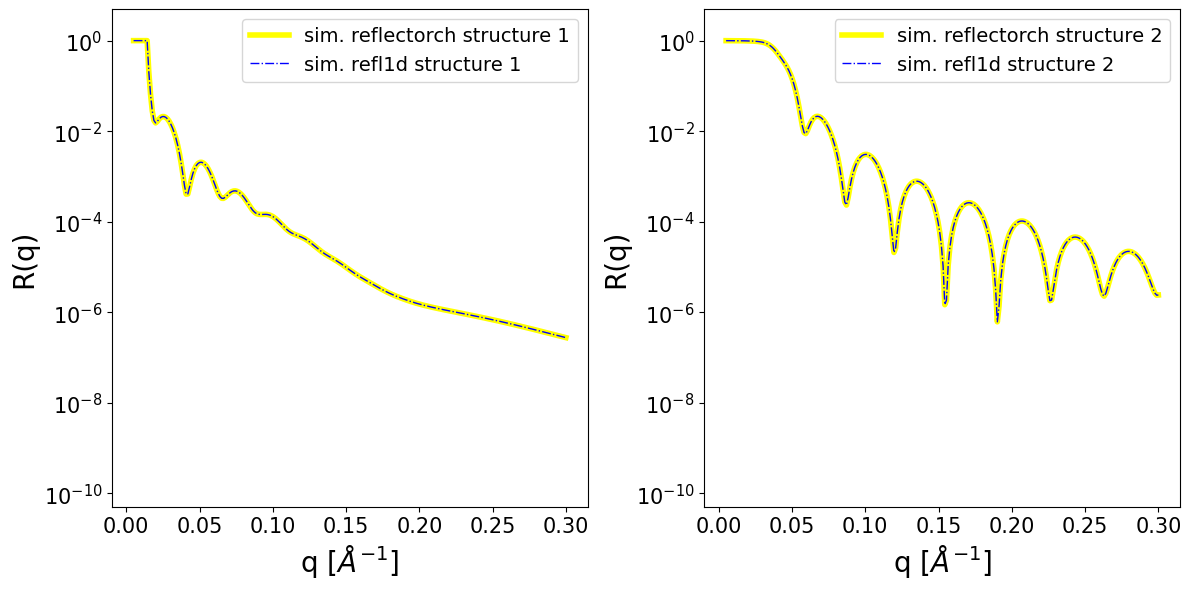

In [9]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(0.5e-10, 5)
    ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax.set_ylabel('R(q)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
axes[0].plot(q, sim_reflectorch[0], c='yellow', lw=4, label='sim. reflectorch structure 1')
axes[0].plot(q.numpy(), sim_refl1d_1, c='blue', lw=1, ls='-.', label='sim. refl1d structure 1')

axes[1].plot(q, sim_reflectorch[1], c='yellow', lw=4, label='sim. reflectorch structure 2')
axes[1].plot(q.numpy(), sim_refl1d_2, c='blue', lw=1, ls='-.', label='sim. refl1d structure 2')

axes[0].legend(loc='upper right', fontsize=14);
axes[1].legend(loc='upper right', fontsize=14);

plt.tight_layout()

In [10]:
print(f'Maximum relative difference (sim 1): {(np.abs((sim_reflectorch[0].numpy() - sim_refl1d_1)) / sim_refl1d_1).max()}')
print(f'Maximum relative difference (sim 2): {(np.abs((sim_reflectorch[1].numpy() - sim_refl1d_2)) / sim_refl1d_2).max()}')

Maximum relative difference (sim 1): 9.961384939109242e-14
Maximum relative difference (sim 2): 3.491715017033277e-14


## Incorporating experimental artifacts

We can incorporate the effects of experimental misalignment (q offset, intensity normalization error) as well as a constant background (relevant in neutron experiments), by providing the following optional arguments to the `reflectivity` function (either as a float or as a tensor of shape [batch_size, 1]):

- `q_shift`: the offset in q due to misalignment
- `r_scale`: a multiplication factor for scaling the intensity of the reflectivity curve
- `background`: the constant background added to the reflectivity curve

In [11]:
device = torch.device('cpu')

q = torch.linspace(0.005, 0.3, 256, dtype=torch.float64, device=device)

thickness = torch.tensor([[60, 120]], dtype=torch.float64, device=device)
roughness = torch.tensor([[20, 40, 10]], dtype=torch.float64, device=device)
sld = torch.tensor([[15, 10, 20]], dtype=torch.float64, device=device)

sim = reflectivity(q=q, thickness=thickness, roughness=roughness, sld=sld)
sim_shifts = reflectivity(q=q, thickness=thickness, roughness=roughness, sld=sld, 
                          q_shift=0.003, r_scale=1.2, background=10**(-5))

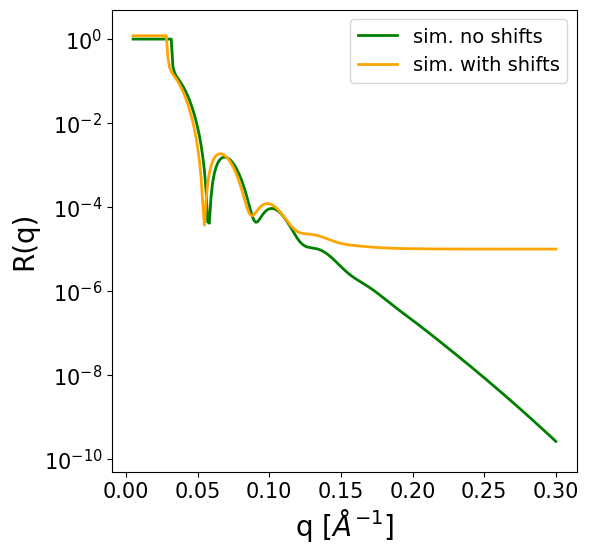

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))

ax.plot(q, sim[0], c='green', lw=2, label='sim. no shifts')
ax.plot(q, sim_shifts[0], c='orange', lw=2, label='sim. with shifts')

ax.legend(loc='upper right', fontsize=14);

## Resolution smearing

In real experiments (particularly for neutrons) the measured reflectivity curves are smeared due to finite resolution in the incident angle and beam energy (which gives a finite resolution in the momentum transfer q). 

In order to apply resolution smearing, the `reflectivity` function takes the following optional arguments:
- `dq` - a tensor containing the smearing coefficients. It has shape [batch_size, 1] for linear and constant smearing, or [batch_size, num_points] for pointwise smearing.
- `constant_dq` - a boolean flag to switch between linear and constant smearing
- `gauss_num` - the number of points used to define the Gaussian smearing kernel. A higher number increases precision at the cost of computational efficiency

### Linear (and constant) smearing

If `dq` is a tensor of shape [batch_size, 1] and `constant_dq` is `False` (default case), *linear smearing* if performed (typical for neutron experiments). In this case, the meaning of the values in the tensor `dq` are not actually dq, but the resolutions s=dq/q for each curve (such that dq=s*q). 

Alternatively, if `dq` is a tensor of shape [batch_size, 1] and  `constant_dq` is `True`, *constant smearing* is performed (sometimes used for x-ray experiments). In this case, the meaning of the values in the tensor are the constant dq for each curve. 

In [13]:
device = torch.device('cpu')
q = torch.linspace(0.02, 0.15, 256, dtype=torch.float64, device=device)

thickness = torch.tensor([
    [200, 150],
    [200, 150],
], dtype=torch.float64, device=device)

roughness = torch.tensor([
    [1, 5, 2],
    [1, 5, 2],
], dtype=torch.float64, device=device)

sld = torch.tensor([
    [4, 2, 6.5],
    [4, 2, 6.5],
], dtype=torch.float64, device=device)

In [14]:
#Two different resolution coefficients for linear smearing (dq/q = 0.05 (5%) and dq/q = 0.1 (10%))

dq = torch.tensor([
    [0.05],
    [0.1],
], dtype=torch.float64, device=device)

print(f'Shape dq: {dq.shape}')

sim_smearing = reflectivity(
    q=q, 
    thickness=thickness, 
    roughness=roughness, 
    sld=sld,
    dq=dq,
    gauss_num=51,
    constant_dq=False,
)

#We compute the unsmeared curve (dq/q=0) separately
sim_no_smearing = reflectivity(
    q=q, 
    thickness=thickness, 
    roughness=roughness, 
    sld=sld,
)

Shape dq: torch.Size([2, 1])


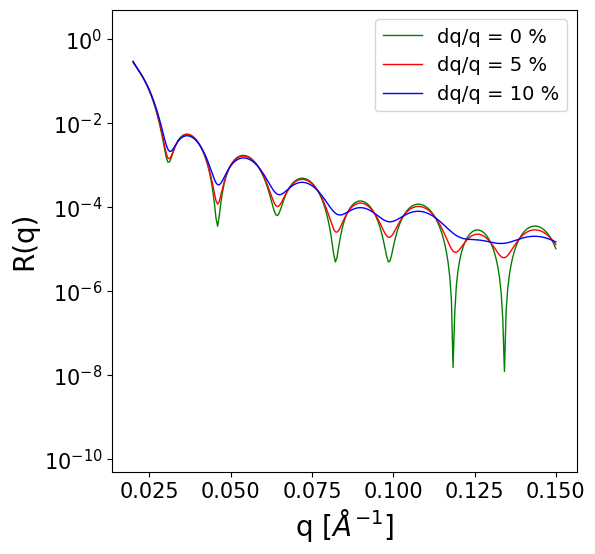

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.plot(q, sim_no_smearing[0], c='g', lw=1, label='dq/q = 0 %')
ax.plot(q, sim_smearing[0], c='r', lw=1, label=f'dq/q = {int(100*dq[0].item())} %')
ax.plot(q, sim_smearing[1], c='b', lw=1, label=f'dq/q = {int(100*dq[1].item())} %')

ax.legend(loc='upper right', fontsize=14);

### Pointwise smearing

If `dq` is a tensor of shape [batch_size, num_points], *pointwise smearing* is performed. This is more general, as dq can be an arbitrary function of q, but it is also more computationally expensive.

In [16]:
thickness = torch.tensor([
    [200, 150],
], dtype=torch.float64, device=device).repeat(4, 1)

roughness = torch.tensor([
    [1, 5, 2],
], dtype=torch.float64, device=device).repeat(4, 1)

sld = torch.tensor([
    [4, 2, 6.5],
], dtype=torch.float64, device=device).repeat(4, 1)

dq_no_smearing = torch.zeros_like(q)
dq_linear_5 = 0.05 * q
dq_linear_10 = 0.1 * q
dq_arbitrary = 0.5*(q**2 + q**3)

dq = torch.stack([
    dq_no_smearing,
    dq_linear_5,
    dq_linear_10,
    dq_arbitrary,
], dim=0)

print(f'Shape dq: {dq.shape}')

sim_smearing_pointwise = reflectivity(
    q=q, 
    thickness=thickness, 
    roughness=roughness, 
    sld=sld,
    dq=dq,
    gauss_num=51,
)

Shape dq: torch.Size([4, 256])


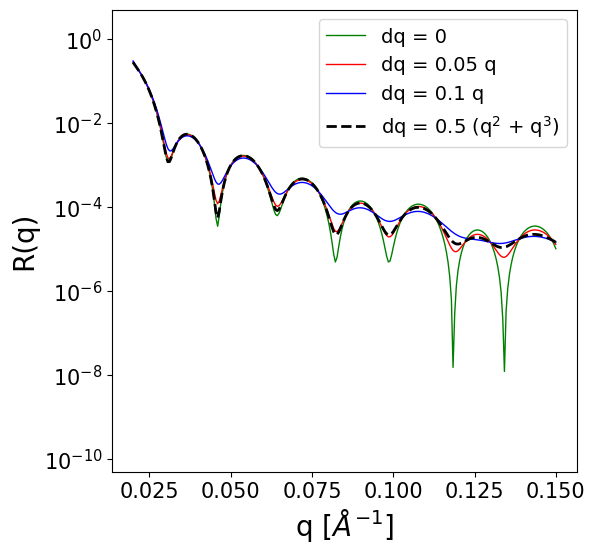

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.plot(q, sim_smearing_pointwise[0], c='g', lw=1, label='dq = 0')
ax.plot(q, sim_smearing_pointwise[1], c='r', lw=1, label=f'dq = 0.05 q')
ax.plot(q, sim_smearing_pointwise[2], c='b', lw=1, label=f'dq = 0.1 q')
ax.plot(q, sim_smearing_pointwise[3], c='black', lw=2, ls='--', label=f'dq = 0.5 (q$^2$ + q$^3$)')

ax.legend(loc='upper right', fontsize=14);